<a href="https://colab.research.google.com/github/Team-Tensor/Face-Recognition/blob/main/CS419_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS419 Project : Team Tensor**
## **Comparison of Face Recognition models using Neural Networks and Principal Component Analysis**

# Imports

In [1]:
import cv2
import numpy as np
from numpy import matlib
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import torch as torch

from google.colab import drive
from google.colab.patches import cv2_imshow
import os
from time import time
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer, LabelEncoder

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install pytorchtools

# Loading Raw Image Data

### Extracting images to arrays and saving to **CSV**

In [2]:
# for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/yalefaces_extended'):
#     filecount=len(filenames)
#     y=torch.empty(filecount, device='cuda:0')
#     X=torch.empty(filecount, 25600, device='cuda:0')    #160x160=25600
#     i=0
#     with tqdm(total=filecount) as pbar:
#       for filename in filenames:
#             b = cv2.imread(os.path.join(dirname, filename),0)
#             b = cv2.resize(b, (160,160),interpolation = cv2.INTER_AREA)

#             X[i]=torch.from_numpy(b.ravel())
#             y[i]=int(filename[5:7])

#             pbar.update(1)
#             i=i+1
#             if i==filecount:
#               break

# np.savetxt('/content/gdrive/MyDrive/yalefaces_extended.csv', 
#            np.concatenate((X.cpu(),y.cpu()[:,None]),axis=1),
#            delimiter =", ", 
#            fmt ='%d')

### Using pre-extracted images from CSV file

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data=np.loadtxt('/content/gdrive/MyDrive/yalefaces_extended.csv', delimiter=',')

In [5]:
X=np.array(data[:,:-1], dtype=np.uint8)
y=data[:,-1]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

# Feature Extraction

## Principal Component Analysis (PCA)

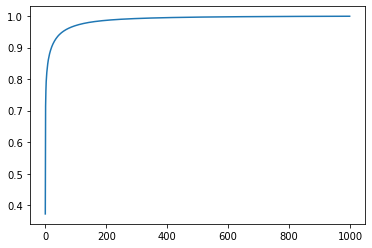

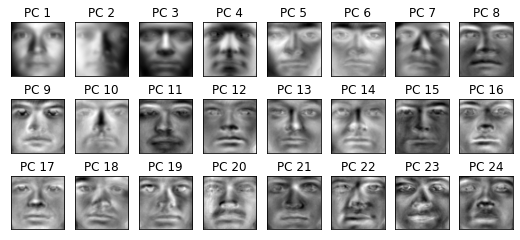

In [7]:
pca = PCA(n_components=1000).fit(x_train)
# Plot cumulative variance captured by the principal components
plt.plot(np.cumsum(pca.explained_variance_ratio_))  

fig, axes = plt.subplots(3, 8, figsize=(9, 4), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(160, 160), cmap='gray')
    ax.set_title("PC " + str(i+1))

Xtrain_pca = normalize(pca.transform(x_train), axis=0)
Xtest_pca = normalize(pca.transform(x_test), axis=0)

## VGG16

### Generate features using VGG16 model

In [8]:
# n=2470
# X_feat = np.empty([n, 224, 224, 3])
# lb = np.empty(n)
# model = VGG16(weights='imagenet', include_top=False)
# for i in tqdm(range(n)):
#   j=np.random.randint(2470)
#   lb[i]=y[j]
#   img = X[j].reshape(160,160)
#   img = cv2.resize(img, (224,224),interpolation = cv2.INTER_AREA)
#   img = preprocess_input(img)

#   b_unroll = img.ravel()
#   b_color = np.matlib.repmat(b_unroll, 1, 3)
#   b_color = b_color.reshape(224, 224, 3)

#   X_feat[i]=b_color


# features=model.predict(X_feat)

# f2=np.empty([n, 25088])
# for i in tqdm(range(n)):
#   f2[i]=features[i].ravel()

# # print(f2.shape)

# np.savetxt('/content/gdrive/MyDrive/yalefaces_extended_vgg16-features2.csv', 
#            np.concatenate((f2,lb[:,None]),axis=1),
#            delimiter =", ", 
#            fmt ='%f')
# del X_feat
# del b_unroll
# del b_color
# del f2
# del lb

### Load previously generated features using VGG16

In [9]:
data=np.loadtxt('/content/gdrive/MyDrive/yalefaces_extended_vgg16-features2.csv', delimiter=',')

In [10]:
X_vgg=data[:,:-1]
y_vgg=data[:,-1]

In [11]:
Xtrain_vgg, Xtest_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y_vgg)

# Models

## SVM (with PCA)

In [12]:
clf = SVC(kernel='rbf',C=1e3,gamma=1e-2)
start_time = time()
clf = clf.fit(Xtrain_pca, y_train)
print("Training Time: ", time()-start_time, "s")
y_pred_svm = clf.predict(Xtest_pca)
print(classification_report(y_test, y_pred_svm))

Training Time:  9.491578340530396 s
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        14
         2.0       1.00      0.95      0.98        22
         3.0       1.00      1.00      1.00        14
         4.0       1.00      0.94      0.97        16
         5.0       1.00      1.00      1.00        13
         6.0       1.00      1.00      1.00        17
         7.0       1.00      0.92      0.96        12
         8.0       0.87      0.87      0.87        15
         9.0       1.00      1.00      1.00        16
        10.0       1.00      0.95      0.97        19
        11.0       1.00      0.84      0.91        19
        12.0       0.92      1.00      0.96        12
        13.0       0.58      1.00      0.73        18
        15.0       1.00      0.83      0.91        12
        16.0       0.93      0.93      0.93        14
        17.0       1.00      0.90      0.95        20
        18.0       1.00      1.00      1.00  

### Improve performance by hyperparameter tuning

In [13]:
# scorer = make_scorer(f1_score, average='macro')

# tuned_parameters = [{'kernel': ['rbf','poly','linear','sigmoid'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
#                      'C': [10, 100, 1000, 10000]}]
# scores = ['precision', 'recall']
# #for score in scores:

# clf = GridSearchCV(SVC(), tuned_parameters, scoring=scorer)
# clf.fit(Normalizer().fit(Xtrain_pca).transform(Xtrain_pca), y_train)
# params=clf.best_params_
# print(clf.best_params_)
# cv= SVC(C=params["C"], gamma= params["gamma"], kernel=params["kernel"])
# cv.fit(Normalizer().fit(Xtrain_pca).transform(Xtrain_pca), y_train)

# y_pred = cv.predict(Normalizer().fit(Xtest_pca).transform(Xtest_pca))
# pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

## SVM (with VGG16)

In [14]:
clf = SVC(kernel='rbf',C=100,gamma=1e-2)
start_time = time()
clf = clf.fit(Xtrain_vgg, y_train_vgg)
print("Training Time: ", time()-start_time, "s")

y_pred_svm_vgg = clf.predict(Xtest_vgg)
print(classification_report(y_test_vgg, y_pred_svm_vgg))

Training Time:  163.97040724754333 s
              precision    recall  f1-score   support

         1.0       1.00      0.67      0.80        21
         2.0       1.00      0.40      0.57        20
         3.0       1.00      0.57      0.73        21
         4.0       1.00      0.37      0.54        19
         5.0       1.00      0.55      0.71        20
         6.0       1.00      0.67      0.80        12
         7.0       1.00      0.50      0.67        10
         8.0       1.00      0.42      0.59        12
         9.0       1.00      0.45      0.62        22
        10.0       1.00      0.62      0.76        13
        11.0       1.00      0.44      0.61        16
        12.0       1.00      0.56      0.72        16
        13.0       1.00      0.50      0.67        16
        15.0       1.00      0.61      0.76        18
        16.0       1.00      0.70      0.82        10
        17.0       1.00      0.53      0.69        17
        18.0       1.00      0.67      0.80 

## Feed-forward Neural Network

In [15]:
class net(nn.Module):
  def __init__(self,input_dim):
    super(net,self).__init__()
    self.bn1=nn.BatchNorm1d(input_dim)
    self.fc1=nn.Linear(input_dim,128)
    self.g1=nn.ReLU()
    #self.bn2=nn.BatchNorm1d(128)
    #self.d1=nn.Dropout(p=0.4)
    self.fc2=nn.Linear(128,128)
    self.g2=nn.ReLU()
    #self.bn3=nn.BatchNorm1d(256)
    self.fc3=nn.Linear(128,128)
    self.g3=nn.ReLU()
    self.fc4=nn.Linear(128,39)
    #self.g4=F.softmax(out, dim=1)
    
  def forward(self, x):
    out=self.bn1(x)
    out=x
    out=self.fc1(out)
    out=self.g1(out)
    #out=F.dropout(out,p=0.2)
    #out=self.bn2(out)
    #out=self.d1(out)
    out=self.fc2(out)
    out=self.g2(out)
    #out=F.dropout(out,p=0.2)
    #out=self.bn3(out)
    out=self.fc3(out)
    out=self.g3(out)
    out=self.fc4(out)
    #out=self.g4(out)
    return out

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(my_net.parameters(), lr=0.003)


In [16]:
def ffnn_output(x_train,y_train,x_test,y_test,n_iters=1000):
  x_train=x_train.astype(np.float32)
  x_test=x_test.astype(np.float32)
  input=torch.tensor(x_train,device=device)
  test_input=torch.tensor(x_test,device=device)
  labels=torch.tensor(y_train-1,dtype=torch.long,device=device)
  test_labels=torch.tensor(y_test-1,dtype=torch.long,device=device)

  loss_record=[]
  my_net=net(x_train.shape[1])
  my_net.to(device)
  m=x_train.shape[0]

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(my_net.parameters(), lr=0.003)
  start_time=time()
  for i in tqdm(range(n_iters)):
    
    optimizer.zero_grad()

    outputs = my_net(input)

    
    loss = criterion(outputs, labels)

    
    loss.backward()

    
    optimizer.step()

    loss_record.append(loss.item()/m)

    
  print("Training Time: ", time()-start_time, "s")
  plt.plot(loss_record)

  y_pred=my_net(test_input)
  y_pred=y_pred.cpu().detach().numpy()
  
  print(classification_report(test_labels.cpu(), np.argmax(y_pred,axis=1)))
  


Training Time:  1.5963103771209717 s
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       1.00      0.75      0.86        16
           2       0.75      0.71      0.73        21
           3       0.93      0.87      0.90        15
           4       0.89      0.67      0.76        12
           5       0.76      0.76      0.76        17
           6       0.69      0.90      0.78        20
           7       0.71      0.75      0.73        16
           8       0.92      0.92      0.92        13
           9       1.00      0.90      0.95        10
          10       0.83      0.62      0.71         8
          11       1.00      0.93      0.96        14
          12       0.56      0.82      0.67        17
          14       0.94      0.94      0.94        16
          15       1.00      0.60      0.75        15
          16       0.89      0.80      0.84        20
          17       1.00      0.71      0.83

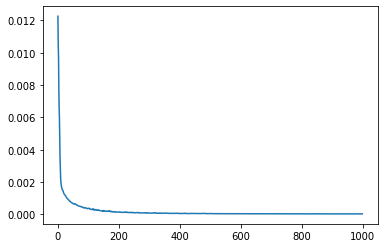

In [17]:
pca_X_csv=X
pca = PCA(n_components=1000).fit_transform(pca_X_csv)
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca, y)
ffnn_output(pca_x_train,pca_y_train, pca_x_test, pca_y_test,1000)

## Logistic Regression (PCA)

In [18]:
x_train=normalize(Xtrain_pca, axis=0)
x_test=normalize(Xtest_pca, axis=0)

# y_train=pca_y_train 
# y_test=pca_y_test

In [19]:
def log_reg_output(x_train,y_train,x_test,y_test):
  log_reg=LogisticRegression(max_iter=1000)

  start_time=time()
  log_reg.fit(x_train,y_train)
  print("Training Time: ", time()-start_time, "s")

  y_pred_logreg=log_reg.predict(x_test)

  print(classification_report(y_test,y_pred_logreg))

log_reg_output(x_train,y_train,x_test,y_test)

Training Time:  0.747314453125 s
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        14
         2.0       1.00      0.95      0.98        22
         3.0       1.00      1.00      1.00        14
         4.0       0.94      1.00      0.97        16
         5.0       1.00      1.00      1.00        13
         6.0       0.94      1.00      0.97        17
         7.0       1.00      1.00      1.00        12
         8.0       1.00      1.00      1.00        15
         9.0       1.00      1.00      1.00        16
        10.0       1.00      1.00      1.00        19
        11.0       1.00      0.89      0.94        19
        12.0       1.00      1.00      1.00        12
        13.0       0.94      0.89      0.91        18
        15.0       1.00      0.92      0.96        12
        16.0       1.00      1.00      1.00        14
        17.0       1.00      0.90      0.95        20
        18.0       0.62      1.00      0.77     

## Logistic Regression (VGG16)

In [20]:
x_train=normalize(Xtrain_vgg, axis=0)
x_test=normalize(Xtest_vgg, axis=0)

y_train=y_train_vgg 
y_test=y_test_vgg

In [21]:
def log_reg_output(x_train,y_train,x_test,y_test):
  log_reg=LogisticRegression(max_iter=1000)

  start_time=time()
  log_reg.fit(x_train,y_train)
  print("Training Time: ", time()-start_time, "s")

  y_pred_logreg=log_reg.predict(x_test)

  print(classification_report(y_test,y_pred_logreg))

log_reg_output(x_train,y_train,x_test,y_test)

Training Time:  29.25606632232666 s
              precision    recall  f1-score   support

         1.0       0.86      0.86      0.86        21
         2.0       0.94      0.75      0.83        20
         3.0       0.90      0.90      0.90        21
         4.0       0.93      0.74      0.82        19
         5.0       0.91      1.00      0.95        20
         6.0       0.83      0.83      0.83        12
         7.0       1.00      0.70      0.82        10
         8.0       1.00      0.83      0.91        12
         9.0       0.87      0.91      0.89        22
        10.0       0.81      1.00      0.90        13
        11.0       0.93      0.88      0.90        16
        12.0       1.00      0.94      0.97        16
        13.0       0.93      0.81      0.87        16
        15.0       0.94      0.83      0.88        18
        16.0       0.83      1.00      0.91        10
        17.0       0.79      0.88      0.83        17
        18.0       0.94      0.94      0.94  

## Convolutional Neural Network (CNN)

In [39]:
x_train_cnn=np.resize(x_train,(x_train.shape[0],160,160))
x_test_cnn=np.resize(x_test,(x_test.shape[0],160,160))
y_train_cnn=y_train
y_test_cnn=y_test

print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train_cnn.shape)
print(y_test_cnn.shape)

x_train_cnn = x_train_cnn.reshape(x_train.shape[0], 1, 160, 160)
x_train_cnn=x_train_cnn.astype(np.float32)
x_train_cnn  = torch.from_numpy(x_train_cnn)

# converting the target into torch format
y_train_cnn = y_train-1
y_train_cnn = y_train_cnn.astype(int);
y_train_cnn = torch.from_numpy(y_train_cnn)

# shape of training data
x_train_cnn.shape, y_train_cnn.shape

x_test_cnn = x_test_cnn.reshape(x_test.shape[0], 1, 160, 160)
x_test_cnn=x_test_cnn.astype(np.float32)
x_test_cnn  = torch.from_numpy(x_test_cnn)

# converting the target into torch format
y_test_cnn = y_test-1
y_test_cnn = y_test_cnn.astype(int);
y_test_cnn = torch.from_numpy(y_test_cnn)

# shape of test data
x_test_cnn.shape, y_test_cnn.shape

(1852, 160, 160)
(618, 160, 160)
(1852,)
(618,)


(torch.Size([618, 1, 160, 160]), torch.Size([618]))

In [40]:
class CNN_Net(nn.Module):
  def __init__(self):
    super(CNN_Net, self).__init__()

    self.conv1=nn.Conv2d(1,12,kernel_size=5)
    self.a1=nn.ReLU()
    self.pool1=nn.MaxPool2d(2,stride=2)
    self.conv2=nn.Conv2d(12,24,kernel_size=4,stride=2)
    self.a2=nn.ReLU()
    self.pool2=nn.MaxPool2d(2)
    self.conv3=nn.Conv2d(24,32,kernel_size=3,stride=2)
    self.a3=nn.ReLU()
    self.pool3=nn.MaxPool2d(2)
    self.fc1 = nn.Linear(512, 120) 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 39)

  def forward(self,out):
    out=self.conv1(out)
    out=self.a1(out)
    out=self.pool1(out)
    out=self.conv2(out)
    out=self.a2(out)
    out=self.pool2(out)
    out=self.conv3(out)
    out=self.a3(out)
    out=self.pool3(out)
    out = torch.flatten(out, 1)
    out=self.fc1(out)
    out=self.fc2(out)
    out=self.fc3(out)

    return out


In [41]:
model = CNN_Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

CNN_Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (a1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2))
  (a2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2))
  (a3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=39, bias=True)
)


In [42]:
from torch.autograd import Variable
x_train_new, y_train_new = Variable(x_train_cnn), Variable(y_train_cnn)
x_val_new, y_val_new = Variable(x_test_cnn[:100]), Variable(y_test_cnn[:100])

"""import pytorchtools
from pytorchtools import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
model.set_callbacks(callbacks)"""

best_loss=100000
flag=0

def train(epoch,x_train=x_train_new, y_train=y_train_new,x_val=x_val_new, y_val=y_val_new,best_loss=best_loss):
    model.train()
    tr_loss = 0
    # getting the training set
    #x_train, y_train = Variable(x_train_cnn), Variable(y_train_cnn)
    # getting the validation set
    #x_val, y_val = Variable(x_test_cnn), Variable(y_test_cnn)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train.item()/y_train.shape[0])
    val_losses.append(loss_val.item()/y_val.shape[0])

    print('Epoch : ',epoch+1, '\t', 'train_loss :', loss_train.item(),'\t', 'test_loss :', loss_val.item())

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()


    #Early stopping
    if best_loss > loss_val.item():
      best_loss= loss_val.item()
      flag = 0
      #torch.save(model.state_dict(), "model_" + str(fold) + 'weight.pt')
      torch.save(model, "/content/best_model.pt")
    else:
        flag += 1
        print("Counter {} of 5".format(es))

        if flag > 4:
          print("Early stopping with best_loss: ", best_loss, "and val_loss for this epoch: ", loss_val.item(), "...")
          return

 


    #if epoch%2 == 0:
        # printing the validation loss
        #print('Epoch : ',epoch+1, '\t', 'loss :', loss_val.item())

In [43]:
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 train_loss : 5.841606616973877 	 test_loss : 6.035068511962891
Epoch :  2 	 train_loss : 4.404585838317871 	 test_loss : 4.255390644073486
Epoch :  3 	 train_loss : 3.989061117172241 	 test_loss : 3.8468146324157715
Epoch :  4 	 train_loss : 3.863755226135254 	 test_loss : 3.7873764038085938
Epoch :  5 	 train_loss : 3.726210117340088 	 test_loss : 3.7190582752227783
Epoch :  6 	 train_loss : 3.64911150932312 	 test_loss : 3.6895995140075684
Epoch :  7 	 train_loss : 3.6104042530059814 	 test_loss : 3.6726412773132324
Epoch :  8 	 train_loss : 3.589515447616577 	 test_loss : 3.6519930362701416
Epoch :  9 	 train_loss : 3.5701353549957275 	 test_loss : 3.6266934871673584
Epoch :  10 	 train_loss : 3.5525593757629395 	 test_loss : 3.6054043769836426
Epoch :  11 	 train_loss : 3.533952474594116 	 test_loss : 3.5878729820251465
Epoch :  12 	 train_loss : 3.5098936557769775 	 test_loss : 3.5698065757751465
Epoch :  13 	 train_loss : 3.480356216430664 	 test_loss : 3.54933309555

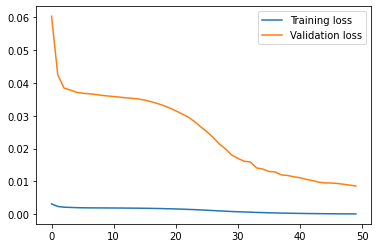

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [45]:
best_model=torch.load("/content/best_model.pt")
best_model.eval()

CNN_Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (a1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2))
  (a2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2))
  (a3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=39, bias=True)
)

In [46]:
x_test_new=Variable(x_test_cnn)
y_pred_cnn=best_model(x_test_new.cuda())
y_pred_cnn=y_pred_cnn.cpu().detach().numpy()
   
print(classification_report(y_test_cnn, np.argmax(y_pred_cnn,axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        16
           1       1.00      0.84      0.91        25
           2       0.83      0.94      0.88        16
           3       0.79      0.92      0.85        12
           4       0.89      0.89      0.89        18
           5       0.91      0.87      0.89        23
           6       0.71      0.88      0.79        17
           7       0.86      0.52      0.65        23
           8       0.72      1.00      0.84        13
           9       1.00      0.87      0.93        15
          10       0.87      0.87      0.87        15
          11       0.84      0.73      0.78        22
          12       0.86      1.00      0.92        18
          14       0.74      0.93      0.82        15
          15       0.85      0.79      0.81        14
          16       0.75      0.86      0.80        14
          17       0.87      0.87      0.87        15
          18       0.87    